In [ ]:
import numpy as np
import torch 
torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
from tqdm import tqdm,trange    
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

import os

print(os.getcwd())  

from flow_model_manipulator import Flow
import open3d as o3d

weights_dir = "../flow_training_weights"
opts_dir = "../flow_training_opts"
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(opts_dir, exist_ok=True)



In [ ]:


torch.set_float32_matmul_precision('high')

# writer = SummaryWriter("./logs")
test = 'manipulator'

In [ ]:
BATCH_SIZE      = 500
LEARNING_RATE   = 1e-3
SEED            = 0
DEVICE          = 'cuda'      
NUM_EPOCH       = 2000

In [ ]:
torch.manual_seed(seed=SEED)
torch.cuda.manual_seed(seed=SEED)

In [ ]:
class TrajDataset(Dataset):
    def __init__(self, theta_init_data, thetadot_init_data, target_pos_data, target_quat_data):
        
        # goal
        self.theta_init = theta_init_data
        self.thetadot_init = thetadot_init_data
        self.target_pos = target_pos_data
        self.target_quat = target_quat_data


        
    
    def __len__(self):
        return len(self.theta_init)    
            
    def __getitem__(self, idx):

        theta_init = self.theta_init[idx]
        thetadot_init = self.thetadot_init[idx]
        target_pos = self.target_pos[idx]
        target_quat = self.target_quat[idx]
                 
        return torch.tensor(theta_init).float(), torch.tensor(thetadot_init).float(), torch.tensor(target_pos).float(), \
            torch.tensor(target_quat).float()

In [ ]:


# One step behind the current working directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_dir)


In [ ]:


# Build relative paths from parent directory
data_dir = os.path.join(parent_dir, "custom_data_['target_2']_inference_False")
pcd_dir = os.path.join(parent_dir, "pcd_data")

print(data_dir)


In [ ]:
# Load the data

theta_init_data = np.loadtxt(os.path.join(data_dir, "theta.csv"), delimiter=",")
thetadot_init_data = np.loadtxt(os.path.join(data_dir, "thetadot.csv"), delimiter=",")
target_pos_data = np.loadtxt(os.path.join(data_dir, "target_positions.csv"), delimiter=",")
target_quat_data = np.loadtxt(os.path.join(data_dir, "target_quaternions.csv"), delimiter=",")
index_data = np.loadtxt(os.path.join(data_dir, "index.csv"), delimiter=",")



pcd_path = os.path.join(pcd_dir, "output_scene_without_robot_unpacked_rgb.pcd")
pcd = o3d.io.read_point_cloud(pcd_path)

# points = np.asarray(pcd.points)       # XYZ points
# colors = np.asarray(pcd.colors)       # RGB (if present)

# Convert Open3D point cloud to a NumPy array
pcd_np = np.asarray(pcd.points)

# Then convert to PyTorch tensor (and move to the correct device)

pcd_tensor = torch.tensor(pcd_np.T, dtype=torch.float32, device=DEVICE).unsqueeze(0)  # shape: [1, 3, length(pcd)]
pcd_tensor = pcd_tensor.permute(2, 1, 0)  # shape: [length(pcd), 3, 1]



print(pcd_tensor.shape)
# print(colors.shape)

print(theta_init_data.shape)
print(thetadot_init_data.shape)
print(target_pos_data.shape)
print(target_quat_data.shape)


In [ ]:
theta_init_mean, theta_init_std = torch.tensor(theta_init_data.mean()).to(DEVICE), torch.tensor(theta_init_data.std()).to(DEVICE)
thetadot_init_mean, thetadot_init_std = torch.tensor(thetadot_init_data.mean()).to(DEVICE), torch.tensor(thetadot_init_data.std()).to(DEVICE)
target_pos_mean, target_pos_std = torch.tensor(target_pos_data.mean()).to(DEVICE), torch.tensor(target_pos_data.std()).to(DEVICE)
target_quat_mean, target_quat_std = torch.tensor(target_quat_data.mean()).to(DEVICE), torch.tensor(target_quat_data.std()).to(DEVICE)


In [ ]:
dataset = TrajDataset(theta_init_data, thetadot_init_data, target_pos_data, target_quat_data, index_data)
print("len(dataset)", len(dataset))

train_size = int(0.9 * len(dataset))  
test_size = len(dataset) - train_size  

# Create a generator with a fixed seed
generator = torch.Generator().manual_seed(0)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

out_chan = 512

flow = Flow(out_chan,theta_init_mean,theta_init_std, thetadot_init_mean, theta_init_std, target_pos_mean, target_pos_std,
            target_quat_mean, target_quat_std).cuda()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE)

In [ ]:
flow.train()
c_flow = torch.compile(flow)


In [ ]:

avg_losses = []
last_loss = torch.inf

NUM_EPOCH = 2
for epoch in range(NUM_EPOCH):
	losses = []
	
	for (theta_init,thetadot_init, target_pos, target_quat, index) in tqdm(train_loader):


		theta_init = theta_init.to(DEVICE)
		thetadot_init = thetadot_init.to(DEVICE)
		target_pos = target_pos.to(DEVICE)
		target_quat = target_quat.to(DEVICE)


		motion_data = torch.cat([theta_init, thetadot_init, target_pos, target_quat], dim=-1)  # or dim=1
		x_1 = motion_data

		x_0 = torch.randn_like(x_1)
		t = torch.rand(len(x_1), 1, 1).to(device=DEVICE)
		x_t = (1 - t) * x_0 + t * x_1

		dx_t = x_1 - x_0
	
		loss = loss_fn(c_flow(x_t, motion_data, t, pcd_tensor), dx_t)
		losses.append(loss.item())

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()


	mean_loss = np.mean(losses)
	avg_losses.append(mean_loss)
	# scheduler.step()

	if epoch % 5 == 0:
		print(f"Epoch: {epoch + 1}, Train Loss: {mean_loss:.3f}")
	#writer.add_scalar('test_{}'.format(test), loss, epoch)

	if loss <= last_loss:
		# torch.save(flow.state_dict(), f"./weights/test_{test}_lowest.pt")
		# torch.save(optimizer.state_dict(), f"./opts/test_{test}_lowest.pt")
		torch.save(flow.state_dict(), f"{weights_dir}/test_{test}.pt")
		torch.save(optimizer.state_dict(), f"{opts_dir}/test_{test}.pt")
		last_loss = loss

In [ ]:
%matplotlib inline
plt.Figure()
plt.plot(avg_losses)
plt.show()

In [ ]:
flow.load_state_dict(torch.load(f"../flow_training_weights/test_{test}.pt"))
# flow.load_state_dict(th.load(f"./weights/test_{test}_lowest.pt"))

flow.eval()

# x_fin,y_fin,theta_init,theta_fin,gt_x,gt_y,index = next(iter(train_loader))

theta_init,thetadot_init, target_pos, target_quat, index = next(iter(train_loader))

# terrain_data = [theta_init, theta_fin, x_fin, y_fin, lam, th.hstack([p1,p2,p3,p4]), cov]

motion_data = torch.cat([theta_init, thetadot_init, target_pos, target_quat], dim=1)


# n_steps = 20
# x_1 = th.stack([gt_x,gt_y], dim=1)
# x_0 = th.randn_like(x_1)
# time_steps = th.linspace(0, 1.0, n_steps + 1, device=DEVICE).unsqueeze(1).unsqueeze(2)

x_1 =  motion_data.to(DEVICE)
#x_1 = x_1.unsqueeze(2)

x_1 = x_1.unsqueeze(1).repeat(1, 95, 1)

x_0 = torch.randn_like(x_1).to(DEVICE)

pcd_tensor = pcd_tensor.to(DEVICE)

x = x_0.clone().to(DEVICE)

time_steps = torch.linspace(0, 1.0, n_steps + 1).unsqueeze(1).unsqueeze(2)
time_steps = time_steps.to(DEVICE)

print(x.shape)


torch.Size([95, 95, 19])


/tmp/ipykernel_509298/120325064.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load(f"../flow_training_weights/test_{test}.pt"))


ValueError: num must be an integer with 1 <= num <= 16, not 17

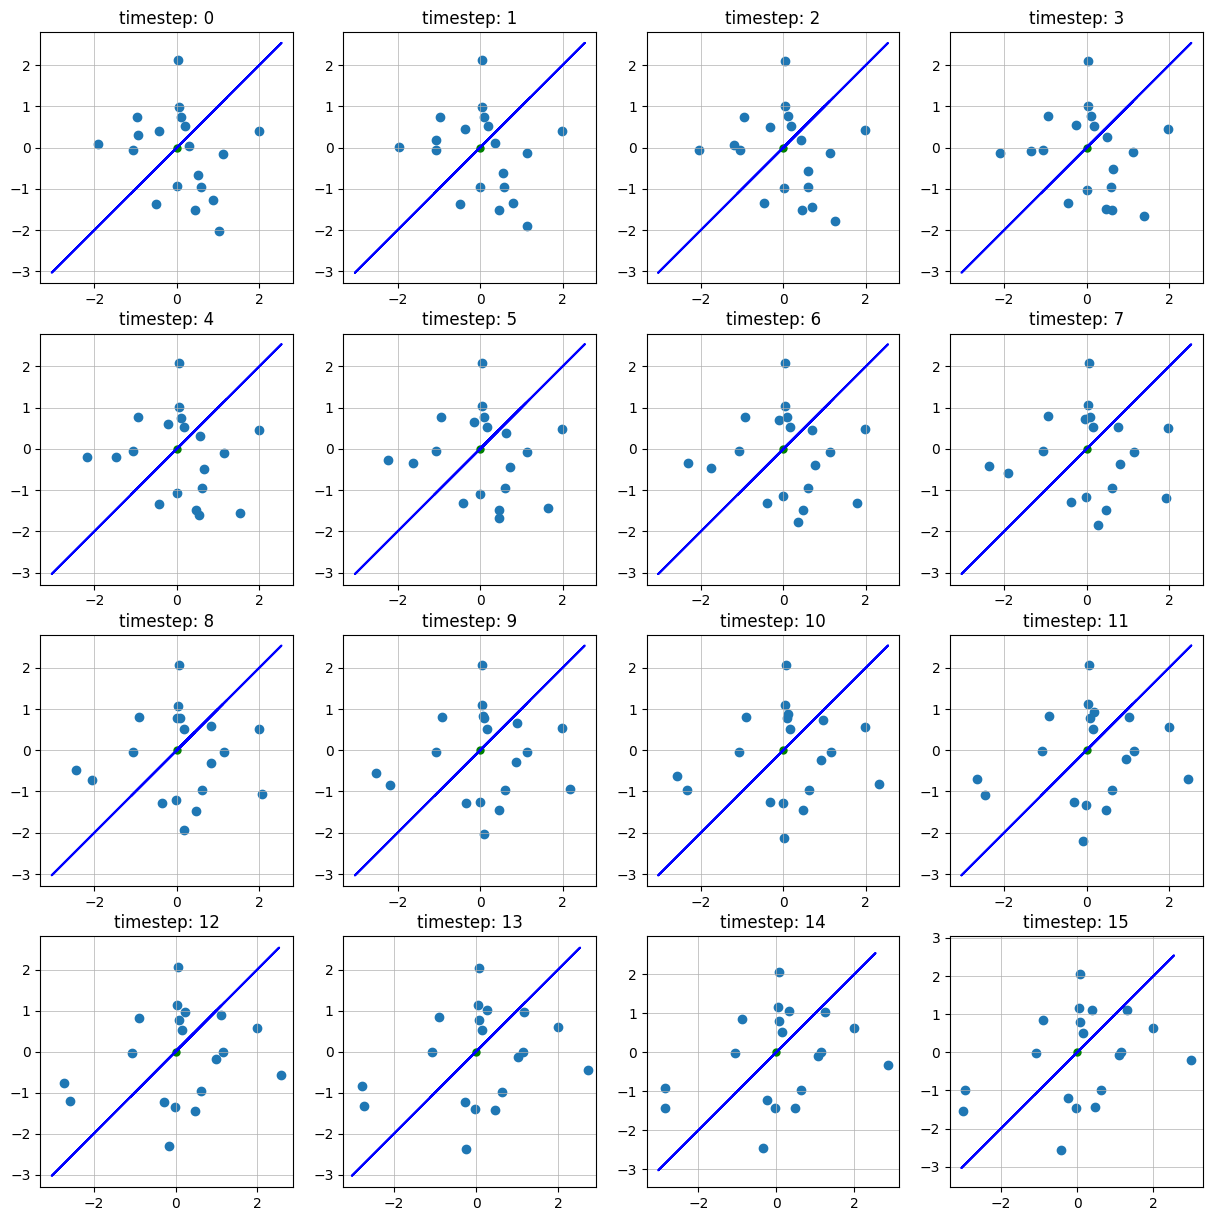

In [ ]:

# t = torch.rand(len(x_1), 1, 1).to(device=DEVICE)
# x_t = (1 - t) * x_0 + t * x_1
n_steps = 20

fig = plt.figure(figsize=(15, 15)) 
for t in range(n_steps):
	ax = fig.add_subplot(4, 4, t+1)
	
	with torch.inference_mode():

		x = flow.step(x, motion_data, time_steps[t].expand(x_0.shape[0],-1,-1), time_steps[t + 1].expand(x_0.shape[0],-1,-1), pcd_tensor)
    
	ax.scatter(x[0, 0, :].detach().cpu().numpy(), x[0, 1, :].detach().cpu().numpy())
	ax.plot(0, 0, 'og', markersize=5)
	
	# ax.plot(x_fin[0].detach().cpu().numpy(), y_fin[0].detach().cpu().numpy(), 'or', markersize=5)
	# ax.plot(gt_x[0, :].detach().cpu().numpy(), gt_y[0, :].detach().cpu().numpy(), 'r')

	ax.plot(x_1[0, 0, :].detach().cpu().numpy(), x_1[0, 1, :].detach().cpu().numpy(), 'b')
	ax.plot(target_pos[0, 0].detach().cpu().numpy(), target_pos[0, 1].detach().cpu().numpy(), 'b')

	ax.axis('equal')
	ax.set_title(f'timestep: {t}')
	ax.grid("both", linewidth=0.5)

plt.tight_layout()
plt.show()